In [1]:
import os,time
import glob
import SimpleITK as sitk
import matplotlib.pyplot as plt
%matplotlib inline

%run update_path_to_download_script
#from downloaddata import fetch_data as fdata

#from downloaddata import fetch_data_all
import numpy as np

# import tensorflow as tf
# import tensorlayer as tl
# from tensorlayer.layers import *

inputDir = 'z:/train'
outputDir = 'output'

ERROR:root:File `'update_path_to_download_script.py'` not found.


In [6]:
pip install SimpleITK



The following command must be run outside of the IPython shell:

    $ pip install SimpleITK

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more information on how to install packages:

    https://docs.python.org/3/installing/


In [2]:
def myshow(img, title=None, margin=0.05, dpi=100):
    nda = sitk.GetArrayViewFromImage(img)
    spacing = img.GetSpacing()
        
    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]
        
        # the the number of components is 3 or 4 consider it an RGB image
        if not c in (3,4):
            nda = nda[nda.shape[0]//2,:,:]
    
    elif nda.ndim == 4:
        c = nda.shape[-1]
        
        if not c in (3,4):
            raise Runtime("Unable to show 3D-vector Image")
            
        # take a z-slice
        nda = nda[nda.shape[0]//2,:,:,:]
            
    ysize = nda.shape[0]
    xsize = nda.shape[1]
      
    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (4 + margin) * ysize / dpi, (4 + margin) * xsize / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
   
    extent = (0, xsize*spacing[1], ysize*spacing[0], 0)
    
    t = ax.imshow(nda,extent=extent,interpolation=None)
    
    if nda.ndim == 2:
        t.set_cmap("gray")
    
    if(title):
        plt.title(title)

In [3]:
def loadData( inputDir, padding=0 ):
    imageflairFilenames = glob.glob(os.path.join(inputDir, "Utrecht", "*","pre","FLAIR.nii.gz"))
    imageT1Filenames = glob.glob(os.path.join(inputDir, "Utrecht", "*","pre","T1.nii.gz"))
    labelFilenames= glob.glob(os.path.join(inputDir, "Utrecht", "*","wmh.nii.gz"))
    images = None # shape: (numImages, z, y, x, channels=1)
    labels = None
    masks  = None
    
    for imageflairFilenames, imageT1Filenames, labelFilenames in zip(imageflairFilenames, imageT1Filenames, labelFilenames):
        # Load the images
        flairImage = sitk.ReadImage(imageflairFilenames)
        T1Image = sitk.ReadImage(imageT1Filenames)
        labelImage = sitk.ReadImage(labelFilenames)
        # Convert to arrays
        flairArray = np.pad(sitk.GetArrayFromImage(flairImage), [(0,0),(padding,padding),(padding,padding)], 'constant')
        T1Array = np.pad(sitk.GetArrayFromImage(T1Image), [(0,0),(padding,padding),(padding,padding)], 'constant')
        labelArray = np.pad(sitk.GetArrayFromImage(labelImage), [(0,0),(padding,padding),(padding,padding)], 'constant')
        maskArray = labelArray > 0
        
        # Add to the images/labels array
        if images is None:
            images = flairArray.reshape([1] + list(flairArray.shape) + [1])
            images = np.concatenate([images, T1Array.reshape([1] + list(T1Array.shape) + [1])], axis=4)
            labels = labelArray.reshape([1] + list(labelArray.shape) + [1])
            masks  = maskArray.reshape([1] + list(maskArray.shape) + [1])
        else:
            tempArray = np.concatenate([flairArray.reshape([1] + list(flairArray.shape) + [1]), T1Array.reshape([1] + list(T1Array.shape) + [1])], axis=4)
            
            images = np.concatenate([images, tempArray])
            
            labels = np.concatenate([labels, labelArray.reshape([1] + list(labelArray.shape) + [1])])
            masks  = np.concatenate([masks, maskArray.reshape([1] + list(maskArray.shape) + [1])])
                    
    return images, labels, masks

In [4]:
testImages, testLabels, testMasks = loadData(inputDir)
testNonZeroIdx = np.nonzero(testMasks)

In [5]:
X = np.asarray(testImages[10])
y = np.asarray(testLabels[10])
print(X.shape, X.min(), X.max()) # (240, 240, 4) -0.380588 2.62761
print(y.shape, y.min(), y.max()) # (240, 240, 1) 0 1 

(48, 240, 240, 2) 0.0 2527.0
(48, 240, 240, 1) 0.0 2.0


In [6]:
X_f = X[:,:,:,0]
y_f = y[:,:,:,0]

In [7]:
X_f.shape

(48, 240, 240)

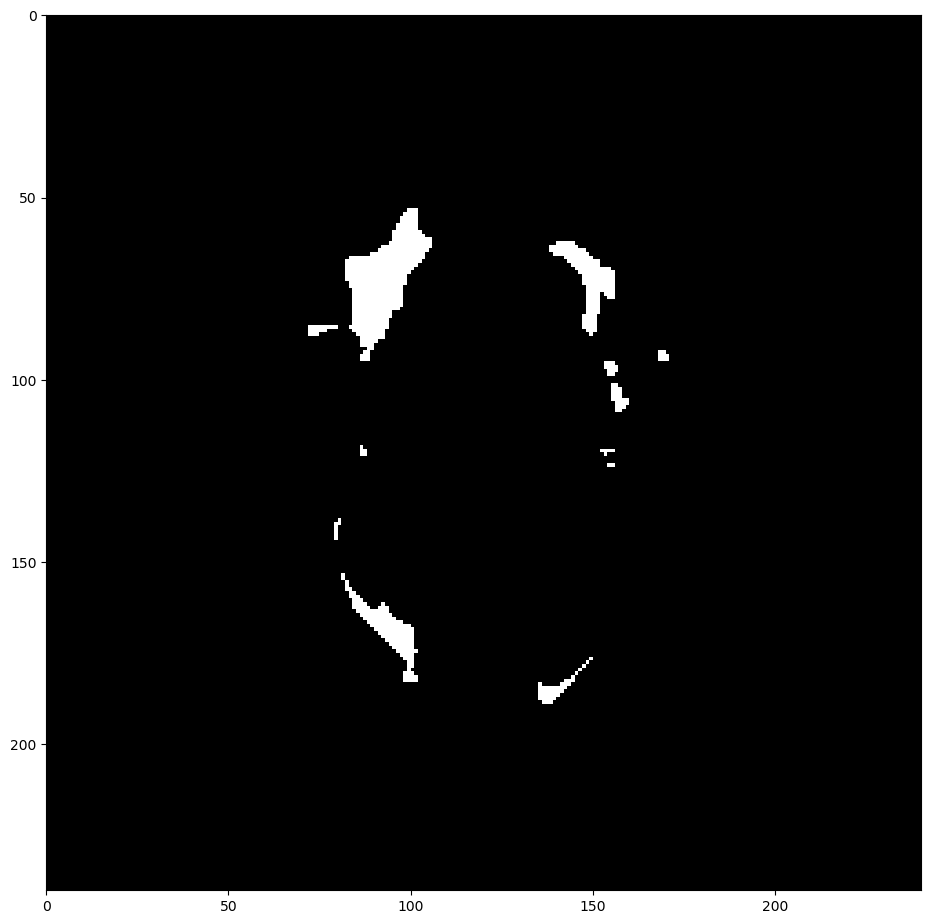

In [8]:
myshow(sitk.GetImageFromArray(y))

# U_net tensorflow


In [12]:
batch_size = 10
lr = 0.0001 
# lr_decay = 0.5
# decay_every = 100
beta1 = 0.9
n_epoch = 100
print_freq_step = 100

In [13]:
nw, nh, nz = X.shape[1:]
print(nw, nh, nz)

240 240 2


In [ ]:
## nz is 4 as we input all Flair, T1, T1c and T2.
t_image = tf.placeholder('float32', [batch_size, nw, nh, nz], name='input_image')
## labels are either 0 or 1
t_seg = tf.placeholder('float32', [batch_size, nw, nh, 1], name='target_segment')
## train inference
net = u_net(t_image, is_train=True, reuse=False, n_out=1)
## test inference
net_test = u_net(t_image, is_train=False, reuse=True, n_out=1)


In [8]:
def u_net(x, is_train=False, reuse=False, n_out=1):
    _, nx, ny, nz = x.get_shape().as_list()
    with tf.variable_scope("u_net", reuse=reuse):
        tl.layers.set_name_reuse(reuse)
        inputs = InputLayer(x, name='inputs')
        conv1 = Conv2d(inputs, 64, (3, 3), act=tf.nn.relu, name='conv1_1')
        conv1 = Conv2d(conv1, 64, (3, 3), act=tf.nn.relu, name='conv1_2')
        pool1 = MaxPool2d(conv1, (2, 2), name='pool1')
        conv2 = Conv2d(pool1, 128, (3, 3), act=tf.nn.relu, name='conv2_1')
        conv2 = Conv2d(conv2, 128, (3, 3), act=tf.nn.relu, name='conv2_2')
        pool2 = MaxPool2d(conv2, (2, 2), name='pool2')
        conv3 = Conv2d(pool2, 256, (3, 3), act=tf.nn.relu, name='conv3_1')
        conv3 = Conv2d(conv3, 256, (3, 3), act=tf.nn.relu, name='conv3_2')
        pool3 = MaxPool2d(conv3, (2, 2), name='pool3')
        conv4 = Conv2d(pool3, 512, (3, 3), act=tf.nn.relu, name='conv4_1')
        conv4 = Conv2d(conv4, 512, (3, 3), act=tf.nn.relu, name='conv4_2')
        pool4 = MaxPool2d(conv4, (2, 2), name='pool4')
        conv5 = Conv2d(pool4, 1024, (3, 3), act=tf.nn.relu, name='conv5_1')
        conv5 = Conv2d(conv5, 1024, (3, 3), act=tf.nn.relu, name='conv5_2')

        up4 = DeConv2d(conv5, 512, (3, 3), (nx/8, ny/8), (2, 2), name='deconv4')
        up4 = ConcatLayer([up4, conv4], 3, name='concat4')
        conv4 = Conv2d(up4, 512, (3, 3), act=tf.nn.relu, name='uconv4_1')
        conv4 = Conv2d(conv4, 512, (3, 3), act=tf.nn.relu, name='uconv4_2')
        up3 = DeConv2d(conv4, 256, (3, 3), (nx/4, ny/4), (2, 2), name='deconv3')
        up3 = ConcatLayer([up3, conv3], 3, name='concat3')
        conv3 = Conv2d(up3, 256, (3, 3), act=tf.nn.relu, name='uconv3_1')
        conv3 = Conv2d(conv3, 256, (3, 3), act=tf.nn.relu, name='uconv3_2')
        up2 = DeConv2d(conv3, 128, (3, 3), (nx/2, ny/2), (2, 2), name='deconv2')
        up2 = ConcatLayer([up2, conv2], 3, name='concat2')
        conv2 = Conv2d(up2, 128, (3, 3), act=tf.nn.relu,  name='uconv2_1')
        conv2 = Conv2d(conv2, 128, (3, 3), act=tf.nn.relu, name='uconv2_2')
        up1 = DeConv2d(conv2, 64, (3, 3), (nx/1, ny/1), (2, 2), name='deconv1')
        up1 = ConcatLayer([up1, conv1] , 3, name='concat1')
        conv1 = Conv2d(up1, 64, (3, 3), act=tf.nn.relu, name='uconv1_1')
        conv1 = Conv2d(conv1, 64, (3, 3), act=tf.nn.relu, name='uconv1_2')
        conv1 = Conv2d(conv1, n_out, (1, 1), act=tf.nn.sigmoid, name='uconv1')
    return conv1


# 对应图 Conv2d MaxPool2d

In [10]:
with tf.device('/cpu:0'):
        sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
        with tf.device('/gpu:0'): #<- remove it if you train on CPU or other GPU
            ###======================== DEFIINE MODEL =======================###
            ## nz is 4 as we input all Flair, T1, T1c and T2.
            t_image = tf.placeholder('float32', [batch_size, nw, nh, nz], name='input_image')
            ## labels are either 0 or 1
            t_seg = tf.placeholder('float32', [batch_size, nw, nh, 1], name='target_segment')
            ## train inference
            net = u_net(t_image, is_train=True, reuse=False, n_out=1)
            ## test inference
            net_test = u_net(t_image, is_train=False, reuse=True, n_out=1)

            ###======================== DEFINE LOSS =========================###
            ## train losses
            out_seg = net.outputs
            dice_loss = 1 - tl.cost.dice_coe(out_seg, t_seg, axis=[0,1,2,3])#, 'jaccard', epsilon=1e-5)
            iou_loss = tl.cost.iou_coe(out_seg, t_seg, axis=[0,1,2,3])
            dice_hard = tl.cost.dice_hard_coe(out_seg, t_seg, axis=[0,1,2,3])
            loss = dice_loss

            ## test losses
            test_out_seg = net_test.outputs
            test_dice_loss = 1 - tl.cost.dice_coe(test_out_seg, t_seg, axis=[0,1,2,3])#, 'jaccard', epsilon=1e-5)
            test_iou_loss = tl.cost.iou_coe(test_out_seg, t_seg, axis=[0,1,2,3])
            test_dice_hard = tl.cost.dice_hard_coe(test_out_seg, t_seg, axis=[0,1,2,3])
            t_vars = tl.layers.get_variables_with_name('u_net', True, True)
        with tf.device('/gpu:0'):
            with tf.variable_scope('learning_rate'):
                lr_v = tf.Variable(lr, trainable=False)
            train_op = tf.train.AdamOptimizer(lr_v, beta1=beta1).minimize(loss, var_list=t_vars)

        ###======================== LOAD MODEL ==============================###
        tl.layers.initialize_global_variables(sess)
        ## load existing model if possible
        tl.files.load_and_assign_npz(sess=sess, name="save_dir"+'/u_net_{}.npz'.format("all"), network=net)


Instructions for updating: TensorLayer relies on TensorFlow to check name reusing

Instructions for updating: This API is deprecated in favor of `tf.global_variables_initializer`



In [13]:
for epoch in range(0, n_epoch+1):
        epoch_time = time.time()
        ## update decay learning rate at the beginning of a epoch
        # if epoch !=0 and (epoch % decay_every == 0):
        #     new_lr_decay = lr_decay ** (epoch // decay_every)
        #     sess.run(tf.assign(lr_v, lr * new_lr_decay))
        #     log = " ** new learning rate: %f" % (lr * new_lr_decay)
        #     print(log)
        # elif epoch == 0:
        #     sess.run(tf.assign(lr_v, lr))
        #     log = " ** init lr: %f  decay_every_epoch: %d, lr_decay: %f" % (lr, decay_every, lr_decay)
        #     print(log)

        total_dice, total_iou, total_dice_hard, n_batch = 0, 0, 0, 0
        for batch in tl.iterate.minibatches(inputs=X_train, targets=y_train,
                                    batch_size=batch_size, shuffle=True):
            images, labels = batch
            step_time = time.time()
            ## data augumentation for a batch of Flair, T1, T1c, T2 images
            # and label maps synchronously.
            data = tl.prepro.threading_data([_ for _ in zip(images[:,:,:,0, np.newaxis],
                    images[:,:,:,1, np.newaxis], images[:,:,:,2, np.newaxis],
                    images[:,:,:,3, np.newaxis], labels)],
                    fn=distort_imgs) # (10, 5, 240, 240, 1)
            b_images = data[:,0:4,:,:,:]  # (10, 4, 240, 240, 1)
            b_labels = data[:,4,:,:,:]
            b_images = b_images.transpose((0,2,3,1,4))
            b_images.shape = (batch_size, nw, nh, nz)

            ## update network
            _, _dice, _iou, _diceh, out = sess.run([train_op,
                    dice_loss, iou_loss, dice_hard, net.outputs],
                    {t_image: b_images, t_seg: b_labels})
            total_dice += _dice; total_iou += _iou; total_dice_hard += _diceh
            n_batch += 1

            ## you can show the predition here:
            # vis_imgs2(b_images[0], b_labels[0], out[0], "samples/{}/_tmp.png".format(task))
            # exit()

            # if _dice == 1: # DEBUG
            #     print("DEBUG")
            #     vis_imgs2(b_images[0], b_labels[0], out[0], "samples/{}/_debug.png".format(task))

            if n_batch % print_freq_step == 0:
                print("Epoch %d step %d 1-dice: %f hard-dice: %f iou: %f took %fs (2d with distortion)"
                % (epoch, n_batch, _dice, _diceh, _iou, time.time()-step_time))

            ## check model fail
            if np.isnan(_dice):
                exit(" ** NaN loss found during training, stop training")
            if np.isnan(out).any():
                exit(" ** NaN found in output images during training, stop training")

        print(" ** Epoch [%d/%d] train 1-dice: %f hard-dice: %f iou: %f took %fs (2d with distortion)" %
                (epoch, n_epoch, total_dice/n_batch, total_dice_hard/n_batch, total_iou/n_batch, time.time()-epoch_time))

        ## save a predition of training set
        for i in range(batch_size):
            if np.max(b_images[i]) > 0:
                vis_imgs2(b_images[i], b_labels[i], out[i], "samples/{}/train_{}.png".format(task, epoch))
                break
            elif i == batch_size-1:
                vis_imgs2(b_images[i], b_labels[i], out[i], "samples/{}/train_{}.png".format(task, epoch))

        ###======================== EVALUATION ==========================###
        total_dice, total_iou, total_dice_hard, n_batch = 0, 0, 0, 0
        for batch in tl.iterate.minibatches(inputs=X_test, targets=y_test,
                                        batch_size=batch_size, shuffle=True):
            b_images, b_labels = batch
            _dice, _iou, _diceh, out = sess.run([test_dice_loss,
                    test_iou_loss, test_dice_hard, net_test.outputs],
                    {t_image: b_images, t_seg: b_labels})
            total_dice += _dice; total_iou += _iou; total_dice_hard += _diceh
            n_batch += 1

        print(" **"+" "*17+"test 1-dice: %f hard-dice: %f iou: %f (2d no distortion)" %
                (total_dice/n_batch, total_dice_hard/n_batch, total_iou/n_batch))
        print(" task: {}".format(task))
        ## save a predition of test set
        for i in range(batch_size):
            if np.max(b_images[i]) > 0:
                vis_imgs2(b_images[i], b_labels[i], out[i], "samples/{}/test_{}.png".format(task, epoch))
                break
            elif i == batch_size-1:
                vis_imgs2(b_images[i], b_labels[i], out[i], "samples/{}/test_{}.png".format(task, epoch))

        ###======================== SAVE MODEL ==========================###
        tl.files.save_npz(net.all_params, name=save_dir+'/u_net_{}.npz'.format(task), sess=sess)

NameError: name 'X_train' is not defined

## U_net keras


In [9]:

from __future__ import print_function

import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout,UpSampling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

C:\Users\Jing\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [11]:
batchShape[1:]

NameError: name 'batchShape' is not defined

In [12]:
def get_unet():
#     inputs = Input((img_rows, img_cols, 2))
#     conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
#     conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#     conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
#     conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#     conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
#     conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#     conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
#     conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

#     conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
#     conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

#     up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
#     conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
#     conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

#     up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
#     conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
#     conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

#     up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
#     conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
#     conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

#     up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
#     conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
#     conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

#     conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

#     model = Model(inputs=[inputs], outputs=[conv10])

#     model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
    inputs = Input(batchShape[1:])
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = -1)
    conv6 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = -1)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = -1)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = -1)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)


    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    model.summary()
    return model

In [13]:
imgs.shape[0]

NameError: name 'imgs' is not defined

In [14]:
def preprocess(imgs):
#     print("pree",imgs.shape, imgs.shape[:-1])
    imgs_p = np.ndarray((imgs.shape[0],img_rows, img_cols,imgs.shape[-1]), dtype=np.uint8)
#     print("imgs.shape[0]",imgs.shape[0])
    for i in range(imgs.shape[0]):
        imgs_p[i] = resize(imgs[i],(img_cols, img_rows,imgs.shape[-1]), preserve_range=True)
#         print("imgs_p[i]",imgs_p[i].shape)
#     imgs_p = imgs_p[..., np.newaxis]
    
#     print("imgs_p",imgs_p.shape)
    return imgs_p

In [15]:
help(resize)

Help on function resize in module skimage.transform._warps:

resize(image, output_shape, order=1, mode=None, cval=0, clip=True, preserve_range=False)
    Resize image to match a certain size.
    
    Performs interpolation to up-size or down-size images. For down-sampling
    N-dimensional images by applying a function or the arithmetic mean, see
    `skimage.measure.block_reduce` and `skimage.transform.downscale_local_mean`,
    respectively.
    
    Parameters
    ----------
    image : ndarray
        Input image.
    output_shape : tuple or ndarray
        Size of the generated output image `(rows, cols[, dim])`. If `dim` is
        not provided, the number of channels is preserved. In case the number
        of input channels does not equal the number of output channels a
        3-dimensional interpolation is applied.
    
    Returns
    -------
    resized : ndarray
        Resized version of the input.
    
    Other parameters
    ----------------
    order : int, optional


In [16]:
X.shape

(48, 240, 240, 2)

In [17]:
xt = y[20,:,:,:]
xt.shape

(240, 240, 1)

In [18]:
myshow(sitk.GetImageFromArray(xt[:,:,1]))

IndexError: index 1 is out of bounds for axis 2 with size 1

In [19]:
y.shape


(48, 240, 240, 1)

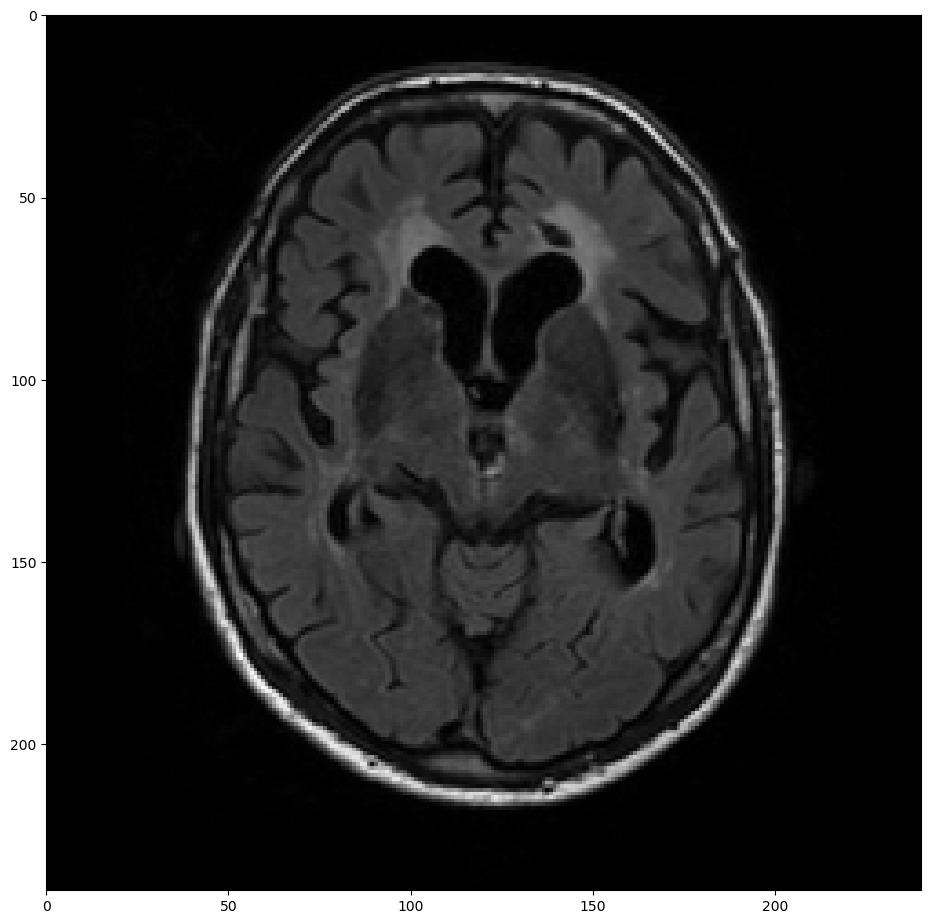

In [20]:
myshow(sitk.GetImageFromArray(X[20,:,:,0]))

In [21]:
def train_and_predict():
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)
    imgs_train, imgs_mask_train = X[10:30,:,:,:], y[10:30,:,:,:]#load_train_data()
#     myshow(sitk.GetImageFromArray(imgs_train[:,:,0]))
#     myshow(sitk.GetImageFromArray(imgs_train[:,:,1]))
#     myshow(sitk.GetImageFromArray(imgs_mask_train))
#     print("shape before",imgs_train.shape,imgs_mask_train.shape)
#     myshow(sitk.GetImageFromArray(imgs_train))

    imgs_train = preprocess(imgs_train)
    imgs_mask_train = preprocess(imgs_mask_train)
    print("shapeagfter",imgs_train.shape,imgs_mask_train.shape)
#     myshow(sitk.GetImageFromArray(imgs_train))

    imgs_train = imgs_train.astype('float32')
    mean = np.mean(imgs_train)  # mean for data centering
    std = np.std(imgs_train)  # std for data normalization

    imgs_train -= mean
    imgs_train /= std

    imgs_mask_train = imgs_mask_train.astype('float32')
    imgs_mask_train /= 255.  # scale masks to [0, 1]

    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet()
    model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

    print('-'*30)
    print('Fitting model...')
    print('-'*30)
# #     myshow(sitk.GetImageFromArray(imgs_train))
#     myshow(sitk.GetImageFromArray(imgs_mask_train))
#     print("before model",imgs_train.shape,imgs_mask_train.shape)
    model.fit(imgs_train, imgs_mask_train, batch_size=20, epochs=5, verbose=1, shuffle=True,
              validation_split=0.2,
              callbacks=[model_checkpoint])
    
    
    print('-'*30)
    print('Loading and preprocessing test data...')
    print('-'*30)
    testrange = [30,31,32,33,34]
    imgs_test, imgs_id_test = X[testrange,:,:,:], y[testrange,:,:,:]
#     print("before test pre",imgs_test.shape,imgs_id_test)
    imgs_test = preprocess(imgs_test)
#     print("after test pre",imgs_test.shape,imgs_id_test)
    imgs_test = imgs_test.astype('float32')
    imgs_test -= mean
    imgs_test /= std

    print('-'*30)
    print('Loading saved weights...')
    print('-'*30)
    model.load_weights('weights.h5')

    print('-'*30)
    print('Predicting masks on test data...')
    print('-'*30)
#     print("test model",imgs_test.shape)
    imgs_mask_test = model.predict(imgs_test, verbose=1)
#     print("test model finished",imgs_mask_test.shape)
    np.save('imgs_mask_test.npy', imgs_mask_test)
    myshow(sitk.GetImageFromArray(imgs_test[1,:,:,1]))
    myshow(sitk.GetImageFromArray(imgs_mask_test[1,:,:,0]))
    print('-' * 30)
    print('Saving predicted masks to files...')
    print('-' * 30)
    pred_dir = 'preds'
    if not os.path.exists(pred_dir):
        os.mkdir(pred_dir)
    for image, image_id in zip(imgs_mask_test, testrange):
#         print(image_id)
        nn = 0
#         print(image.shape)
        image = (image[:, :, 0] * 255.).astype(np.uint8)
        imsave(os.path.join(pred_dir,str(image_id) + '_pred.png'), image)
        nn+=1

In [22]:
[30,31]

[30, 31]

In [23]:
img_rows =256
img_cols =256

smooth = 1.


In [24]:

batchSize = 20
batchShape = (batchSize, 256,256, 2)


------------------------------
Loading and preprocessing train data...
------------------------------


C:\Users\Jing\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


shapeagfter (20, 256, 256, 2) (20, 256, 256, 1)
------------------------------
Creating and compiling model...
------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 2)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 608         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 32) 0           c

Train on 16 samples, validate on 4 samples
Epoch 1/5
16/16 [==============================] - 19s 1s/step - loss: 0.2890 - acc: 0.9487 - val_loss: 0.2827 - val_acc: 0.9430
Epoch 2/5
16/16 [==============================] - 15s 945ms/step - loss: 0.1389 - acc: 0.9736 - val_loss: 0.1660 - val_acc: 0.9715
Epoch 3/5
16/16 [==============================] - 14s 884ms/step - loss: 0.0680 - acc: 0.9815 - val_loss: 0.0942 - val_acc: 0.9778
Epoch 4/5
16/16 [==============================] - 14s 861ms/step - loss: 0.0395 - acc: 0.9856 - val_loss: 0.0583 - val_acc: 0.9796
Epoch 5/5
16/16 [==============================] - 19s 1s/step - loss: 0.0274 - acc: 0.9868 - val_loss: 0.0383 - val_acc: 0.9801
------------------------------
Loading and preprocessing test data...
------------------------------
------------------------------
Loading saved weights...
------------------------------
------------------------------
Predicting masks on test data...
------------------------------
5/5 [===============

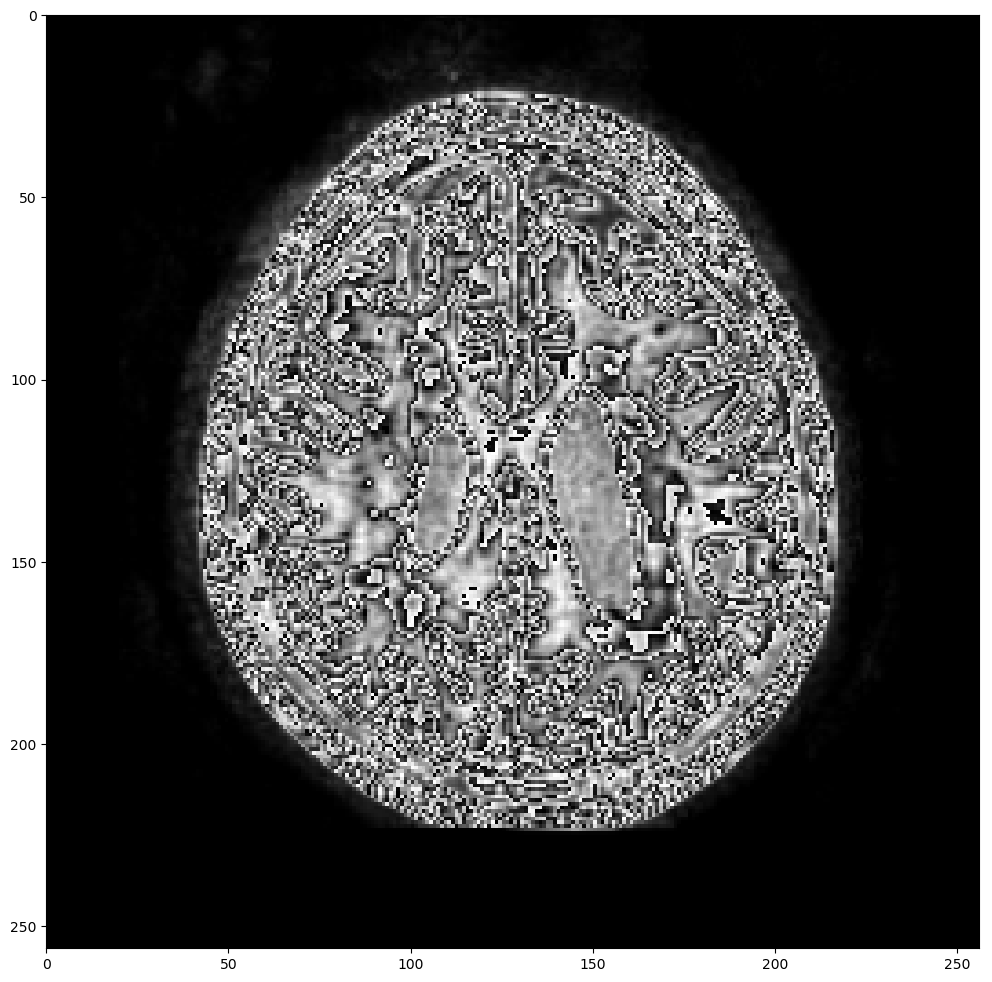

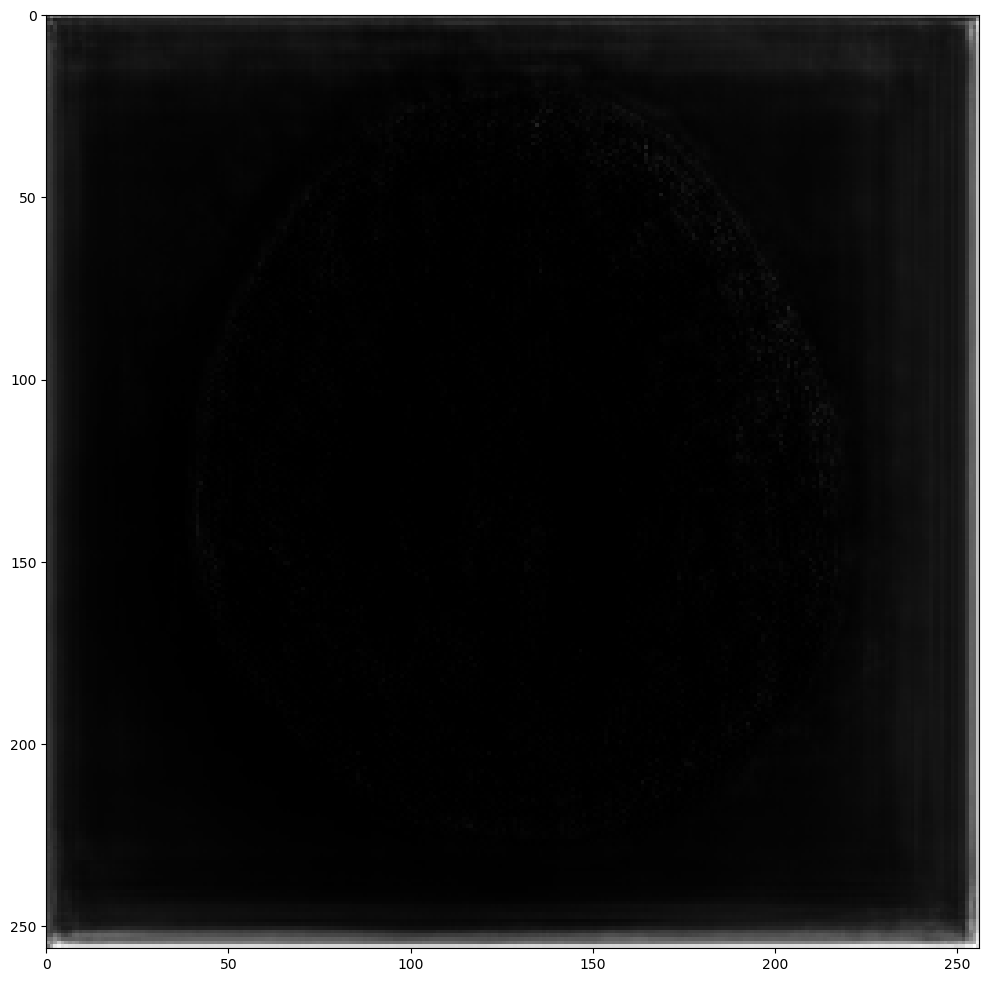

In [25]:
if __name__ == '__main__':
    train_and_predict()
    

### Only flair